## SIMULATION MKV WITH COMMON NOISE

In [ ]:
!pip3 install ipywidgets==8.0.2

In [2]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import multiprocessing
from joblib import Parallel, delayed

In [19]:
# Parameters
N = 10 # number of Brownian motions
M = 1 # number of systems
T = 1 # total time
dt = 1e-4 # time step
sigma = 2 # noise strength
sigma0 = 0.1 # common noise strength
alpha = 0.1 # strength of the interaction
beta = 0.1 # strength of the confinement


In [20]:
def brownian_motion(N, T, dt):
    rand_numbers = np.random.normal(0, 1, (N, int(T/dt)))
    return np.cumsum(np.sqrt(dt) * rand_numbers, axis=1)

In [21]:
def gradV(beta, x):
    return beta * (x**3 - x)

def gradW(alpha,x,y):
    return alpha * (x-y)

In [22]:
def mean_field_interaction(x, alpha, N):
    a = np.tile(x, (N,1))
    res = np.mean(gradW(alpha, a.T, a) , axis=1)
    return res


def euler_step(j, N, x, alpha, beta, sigma, sigma0, B, B0): #sigma0,
    dx = - gradV(beta, x) - mean_field_interaction(x, alpha, N) + sigma * (B[:,j] - B[:,j-1])  + sigma0 * (B0[j] - B0[j-1])
    return x + dx

In [23]:
B = brownian_motion(N, T, dt)
fig = px.line(x = np.linspace(0,1,int(T/dt)), y = B[N-1,:])
fig.show()

In [24]:
def simu_X(N,T,dt, alpha, beta):
    B = brownian_motion(N, T, dt)
    B0 = brownian_motion(1, T, dt).reshape(-1)
    X = np.empty((int(T/dt),N))
    X[0,:] = np.random.uniform(0,0, N)
    for j in range(1,int(T/dt)):
    #for j in tqdm(range(1,int(T/dt)), desc='Iteration over n time steps', colour = 'black', leave = True):
        X[j,:] = euler_step(j, N, X[j-1,:], alpha, beta, sigma, sigma0, B, B0) # sigma0,  
    return X

In [25]:
# Simulation and plot of one particle system
X = simu_X(N,T,dt, alpha, beta)
if False:
    fig = go.Figure()
    for i in range(N):
        fig.add_trace(go.Scatter(x = np.linspace(0,1,int(T/dt)), 
                                y = X[:,i],
                                mode = "lines",
                                name = "Trajectory {}".format(i)))
        
    fig.add_shape(
        type='line',
        x0=0,
        x1=1,
        y0=1,
        y1=1,
        line=dict(color='black', width=1, dash='dash') # Ajout de la propriété dash='dash'
    )
    fig.add_shape(
        type='line',
        x0=0,
        x1=1,
        y0=-1,
        y1=-1,
        line=dict(color='black', width=1, dash='dash') # Ajout de la propriété dash='dash'
    )

    fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white'
    )
    fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


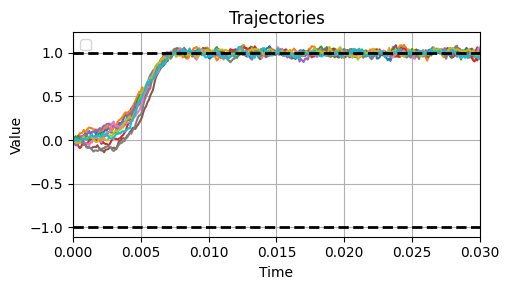

In [26]:
t = np.linspace(0,1,int(T/dt))

plt.figure(figsize=(5, 3),dpi=100)
for i in range(N):
    plt.plot(t, X[:, i])

plt.axhline(1, color='black', linestyle='--', linewidth=2)
plt.axhline(-1, color='black', linestyle='--', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Trajectories')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0,0.03)
plt.show()

In [27]:
barX = np.mean(X, axis = 1)
if True:
    fig = go.Figure()
    for i in range(1):
        fig.add_trace(go.Scatter(x = np.arange(int(T/dt)), 
                                y = abs(X[:,i] - barX),
                                mode = "lines",
                                name = "Convergence particle {}".format(i)))
    fig.show()


In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = np.arange(int(T/dt)), 
                                y = np.mean(abs(X.T-barX),axis=0),
                                mode = "lines"))
fig.show()

In [29]:
m = 0
num_cores = multiprocessing.cpu_count()
modelisation = tqdm(range(M),desc='M systems simulation', colour = 'blue', leave = True)
def simul(i):
    X = simu_X(N,T,dt, alpha, beta)
    barX = np.mean(X, axis = 1)
    return np.mean(abs(X.T-barX),axis=0)

m = Parallel(n_jobs=4)(delayed(simul)(i) for i in modelisation)


M systems simulation: 100%|██████████| 1/1 [00:00<00:00, 265.46it/s]


In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = np.arange(int(T/dt)), 
                                y = np.mean(m, axis = 0),
                                mode = "lines"))
fig.show()

In [31]:
def phi(x):
    return x**2

In [32]:
def mean_phi(X, plot):
    mu = np.mean(phi(X), axis = 1)
    if plot == True:
        fig = px.line(x = np.linspace(0,100,int(T/dt)), y = mu)
        fig.show()
    return mu


In [33]:
m = 0
num_cores = multiprocessing.cpu_count()
modelisation = tqdm(range(M),desc='M systems simulation', colour = 'blue', leave = True)
def simul(i):
    return mean_phi(simu_X(N,T,dt,alpha, beta), False)

m = Parallel(n_jobs=4)(delayed(simul)(i) for i in modelisation)
print(m)
m = np.mean(m, axis = 0)

M systems simulation: 100%|██████████| 1/1 [00:00<00:00, 464.64it/s]


[array([0.00000000e+00, 2.33066728e-04, 4.21498572e-04, ...,
       9.53527053e-01, 9.81183509e-01, 9.82290428e-01])]


In [34]:
fig = px.line(x = np.linspace(0,100,int(T/dt)), y = m)
fig.show()